In [1]:
#Loa d Da ta set 
import struct 
import numpy as np 
import matplotlib.pyplot as plt 
 
# ==========Load IDX Files ========== 
def load_images(filename): 
    with open(filename, 'rb') as f: 
        _, num, rows, cols = struct.unpack(">IIII",f.read(16)) 
        images=np.frombuffer(f.read(), dtype=np.uint8) 
        images = images[:(len(images)//(rows * cols)) * rows * cols] 
        return images.reshape(-1, rows * cols).astype(np.float32) / 255.0 
 
def load_labels(filename): 
    with open(filename, 'rb') as f: 
        _, num = struct.unpack(">II", f.read(8)) 
        labels = np.frombuffer(f.read(),dtype=np.uint8) 
        return labels[:num]

In [2]:
# ========== 1. Sigmoid Function ========== 
def sigmoid(z): 
    a = 1.0 / (1.0 + np.exp(-z))
    return a
 
# ====== 2. Mini Batch SGD: Algorithm 7.2 ====== 
def sgd_minibatch(X, y, eta=0.01, max_iters=10000, batch_size=64): 
        m, n = X.shape 
        theta = np.zeros(n) 
        for i in range(max_iters): 
            indices = np.random.choice(m, batch_size) 
            X_batch = X[indices] 
            y_batch = y[indices] 
            gradient = -X_batch.T @ (y_batch - sigmoid(X_batch @ theta)) / batch_size 
            theta -= eta * gradient 
        return theta
 
# ===== 3. Mini Batch SGD with Momentum: Algorithm 7.3 ===== 
def  sgd_minibatch_momentum(X,  y,  eta=0.01,  max_iters=10000, batch_size=64, momentum=0.9): 
    m, n = X.shape 
    theta = np.zeros(n) 
    v = np.zeros(n) 
    for i in range(max_iters): 
        indices = np.random.choice(m, batch_size) 
        X_batch = X[indices] 
        y_batch = y[indices] 
        gradient = -X_batch.T @ (y_batch - sigmoid(X_batch @ theta)) / batch_size 
        v = momentum * v - eta * gradient 
        theta += v 
    return theta
 
# ====== 4. Adam Optimizer: Algorithm 7.4 ====== 
def sgd_Adam(X, y, eta=0.001, max_iters=10000, batch_size=64, beta1=0.9, beta2=0.999, delta=1e-8): 
    m, n = X.shape 
    theta = np.zeros(n) 
    m1 = np.zeros(n) 
    m2 = np.zeros(n) 
    for i in range(max_iters): 
        indices = np.random.choice(m, batch_size) 
        X_batch = X[indices] 
        y_batch = y[indices] 
        gradient = -X_batch.T @ (y_batch - sigmoid(X_batch @ theta)) / batch_size
        m1 = beta1 * m1 + (1 - beta1) * gradient 
        m2 = beta2 * m2 + (1 - beta2) * gradient ** 2 
        m1_hat = m1 / (1 - beta1 ** (i + 1)) 
        m2_hat = m2 / (1 - beta2 ** (i + 1)) 
        theta -= eta * m1_hat / (np.sqrt(m2_hat) + delta) 
    return theta

In [3]:
# ==========Show Misclassified Samples ========== 
def show_misclassified(X, true_labels, pred_labels, max_show=10): 
    mis_idx = np.where(true_labels != pred_labels)[0][:max_show] 
    plt.figure(figsize=(10, 2)) 
    for i, idx in enumerate(mis_idx): 
        plt.subplot(1, len(mis_idx), i + 1) 
        plt.imshow(X[idx, 1:].reshape(28, 28), cmap='gray') 
        plt.axis('off') 
        plt.title(f"T:{true_labels[idx]} P:{pred_labels[idx]}") 
    plt.suptitle("Misclassified Samples") 
    plt.show()

Train Accuracy: 0.9874
Test Accuracy: 0.9898


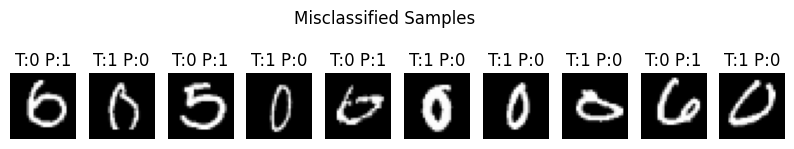

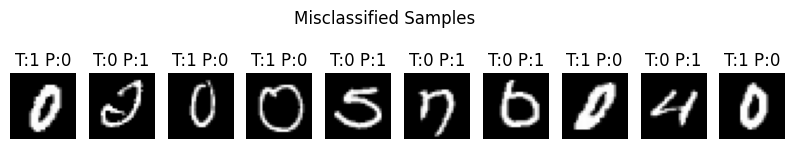

In [6]:
# ========== 3. Main ========== 
if __name__ == "__main__": 
    # === Load Data === 
    X_train = load_images("train-images.idx3-ubyte____") 
    y_train = load_labels("train-labels.idx1-ubyte____") 
    X_test = load_images("t10k-images.idx3-ubyte____") 
    y_test = load_labels("t10k-labels.idx1-ubyte____") 
 
    # === Choose binary classification target digit === 
    TARGET_DIGIT = 0   # TODO: Fill in (0 to 9) 
 
    y_train_bin = np.where(y_train == TARGET_DIGIT, 1, 0) 
    y_test_bin = np.where(y_test == TARGET_DIGIT, 1, 0)
    # === Add bias term === 
    X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train]) 
    X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test]) 
 
    # === Set parameters === 
    eta = 0.01
    max_iters = 100
    batch_size = 64
    momentum = 0.9
    beta1 = 0.9
    beta2 = 0.999
    delta = 1e-8
 
    # === Train === 
    # theta = sgd_minibatch(X_train, y_train_bin, eta, max_iters, batch_size)
    # theta = sgd_minibatch_momentum(X_train, y_train_bin, eta, max_iters, batch_size, momentum) 
    theta = sgd_Adam(X_train, y_train_bin, eta, max_iters, batch_size, beta1, beta2, delta)
 
    # === Predict === 
    y_train_pred = (sigmoid(X_train @ theta) >= 0.5).astype(int)
    y_test_pred = (sigmoid(X_test @ theta) >= 0.5).astype(int)
 
    # === Evaluate === 
    train_accuracy = np.mean(y_train_pred == y_train_bin)
    test_accuracy = np.mean(y_test_pred == y_test_bin)
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
 
    # === Show Misclassified Samples === 
    show_misclassified(X_test, y_test_bin, y_test_pred, max_show=10)
    show_misclassified(X_train, y_train_bin, y_train_pred, max_show=10)
